In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, accuracy_score, classification_report
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import roc_curve, roc_auc_score
from imblearn.under_sampling import RandomUnderSampler
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.preprocessing import StandardScaler

#For Evaluating models.
import eli5
from eli5.sklearn import PermutationImportance

%matplotlib inline
pd.options.display.max_rows = 1000

# Import the pickled modeling data

In [2]:
partd = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partd.pkl')
partb = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/partb.pkl')
dmepos = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/dmepos.pkl')
combined = pd.read_pickle('/Volumes/ML_projects/Medicare_Fraud_Datasets/processed_data/combined.pkl')

# Making targets binary

In [3]:
partb.TARGET = partb.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
partd.TARGET = partd.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
dmepos.TARGET = dmepos.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)
combined.TARGET = combined.TARGET.map({'FRAUD': 1, 'NOT_FRAUD': 0}).astype(int)

# Split data from the targets.

We have 4 datasets total, and in order to test to performance of each we need to split them into training/test sets. We have a lot of data, so we ***could*** create a holdout dataset to test our model. I think the better course of action would be to split the data into training/test sets, then perform K-fold cross validation to confirm the predictive power of the model.

In [4]:
# partb dataset
X_partb = partb.drop(columns=['TARGET'], axis=1)
y_partb = partb.TARGET

#partd dataset
X_partd = partd.drop(columns=['TARGET'], axis=1)
y_partd = partd.TARGET

#dmepos dataset
X_dmepos = dmepos.drop(columns=['TARGET'], axis=1)
y_dmepos = dmepos.TARGET

#combined dataset
X_combined = combined.drop(columns=['TARGET'], axis=1)
y_combined = combined.TARGET

# Downsampling

There is a massive class imbalance in the dataset, with most observations classified as `NOT_FRAUD`, to address this I chose to randomly downsample the majority class. This should still leave us with 2000+ observations in each dataset. [The research used to guide this project](https://journalofbigdata.springeropen.com/articles/10.1186/s40537-018-0138-3) did not address class imbalance.

In [5]:
rus1 = RandomUnderSampler(random_state=42)
X_partb, y_partb = rus1.fit_sample(X_partb, y_partb)

rus2 = RandomUnderSampler(random_state=42)
X_partd, y_partd = rus2.fit_sample(X_partd, y_partd)

rus3 = RandomUnderSampler(random_state=42)
X_dmepos, y_dmepos = rus3.fit_sample(X_dmepos, y_dmepos)

rus4 = RandomUnderSampler(random_state=42)
X_combined, y_combined = rus4.fit_sample(X_combined, y_combined)

# Train/Test split

In [6]:
X_train_b, X_test_b, y_train_b, y_test_b = train_test_split(X_partb, y_partb, test_size=0.2, random_state=0)
X_train_d, X_test_d, y_train_d, y_test_d = train_test_split(X_partd, y_partd, test_size=0.2, random_state=0)
X_train_dmepos, X_test_dmepos, y_train_dmepos, y_test_dmepos = train_test_split(X_dmepos, y_dmepos, test_size=0.2, random_state=0)
X_train_combined, X_test_combined, y_train_combined, y_test_combined = train_test_split(X_combined, y_combined, test_size=0.2, random_state=0)

### Scale the data.

In [7]:
partb_feature_names = X_partb.columns.to_list()

X_partb_scaler = StandardScaler()
X_partb_scaled = X_partb_scaler.fit_transform(X_train_b) #Fit/Transform to the training data


X_train_b = pd.DataFrame(X_partb_scaled, columns=partb_feature_names)

X_test_b = pd.DataFrame(X_partb_scaler.transform(X_test_b), columns=partb_feature_names) #Transform the test set with fitted scaler.

In [8]:
partd_feature_names = X_partd.columns.to_list()

X_partd_scaler = StandardScaler()
X_partd_scaled = X_partd_scaler.fit_transform(X_train_d)

X_train_d = pd.DataFrame(X_partd_scaled, columns=partd_feature_names)
X_test_d = pd.DataFrame(X_partd_scaler.transform(X_test_d), columns=partd_feature_names)

In [9]:
dmepos_feature_names = X_dmepos.columns.to_list()

X_dmepos_scaler = StandardScaler()
X_dmepos_scaled = X_dmepos_scaler.fit_transform(X_train_dmepos)

X_train_dmepos = pd.DataFrame(X_dmepos_scaled, columns=dmepos_feature_names)
X_test_dmepos = pd.DataFrame(X_dmepos_scaler.transform(X_test_dmepos), columns=dmepos_feature_names)

In [10]:
combined_feature_names = X_combined.columns.to_list()

X_combined_scaler = StandardScaler()
X_combined_scaled = X_combined_scaler.fit_transform(X_train_combined)

X_train_combined = pd.DataFrame(X_combined_scaled, columns=combined_feature_names)
X_test_combined = pd.DataFrame(X_combined_scaler.transform(X_test_combined), columns = combined_feature_names)

### Logistic Regression

L1 (Lasso) regression is used to remove the effect of coefficients that provide little predictive power. 

In [11]:
#instantiate the models
logreg_b = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_d = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_dmepos = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')
logreg_combined = LogisticRegression(max_iter=10**4, penalty='l1', solver='saga')

In [12]:
param_grid_logreg = {  
    'penalty': ['l1', 'l2', 'elasticnet'],
    'C': [.01, .05, .001],
}

In [13]:
grid_tree_logreg_b = RandomizedSearchCV(logreg_b, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_d = RandomizedSearchCV(logreg_d, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_dmepos = RandomizedSearchCV(logreg_dmepos, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

grid_tree_logreg_combined = RandomizedSearchCV(logreg_combined, 
                                  param_grid_logreg, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [14]:
#fit the models to the training data
grid_tree_logreg_b.fit(X_train_b, y_train_b)
grid_tree_logreg_d.fit(X_train_d, y_train_d)
grid_tree_logreg_dmepos.fit(X_train_dmepos, y_train_dmepos)
grid_tree_logreg_combined.fit(X_train_combined, y_train_combined)

/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-packages/sklearn/model_selection/_search.py:282: UserWarning: The total space of parameters 9 is smaller than n_iter=10. Running 9 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
/Users/brendanferris/opt/anaconda3/envs/learn-env/lib/python3.6/site-pack

RandomizedSearchCV(cv=5,
                   estimator=LogisticRegression(max_iter=10000, penalty='l1',
                                                solver='saga'),
                   n_jobs=-1,
                   param_distributions={'C': [0.01, 0.05, 0.001],
                                        'penalty': ['l1', 'l2', 'elasticnet']},
                   scoring='f1')

In [15]:
grid_tree_logreg_combined.best_params_

{'penalty': 'l1', 'C': 0.05}

In [16]:
#predict on the test set
y_pred_b = grid_tree_logreg_b.predict(X_test_b)
y_pred_d = grid_tree_logreg_d.predict(X_test_d)
y_pred_dmepos = grid_tree_logreg_dmepos.predict(X_test_dmepos)
y_pred_combined = grid_tree_logreg_combined.predict(X_test_combined)

Shown below are the Logistic Regression confusion matrixes for each dataset. As we can see, the combined dataset has the best performance, correctly classifying 73% of the data.


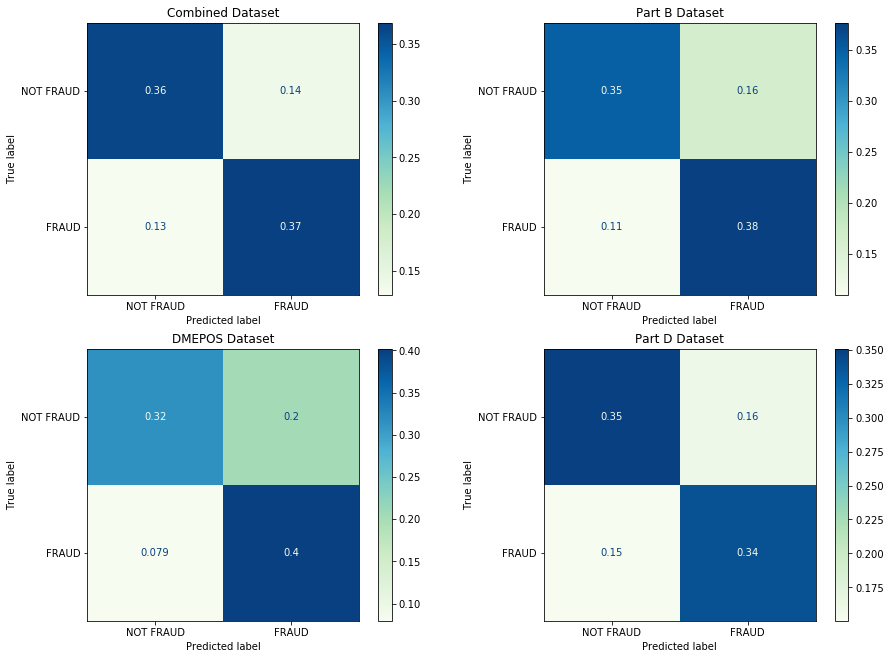

In [32]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(grid_tree_logreg_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(grid_tree_logreg_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(grid_tree_logreg_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_dmepos = metrics.plot_confusion_matrix(grid_tree_logreg_dmepos, X_test_dmepos, y_test_dmepos, cmap= "GnBu", ax = ax[1,0], normalize='all')
ax[1,0].set_title('DMEPOS Dataset')
ax[1,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,0].set_yticklabels(['NOT FRAUD','FRAUD']);

print('Shown below are the Logistic Regression confusion matrixes for each dataset. As we can see, the combined dataset has the best performance, correctly classifying 73% of the data.')

fig.savefig('logreg_confusion.png')

We can see from the ROC curves below that the Combined dataset performs the best.


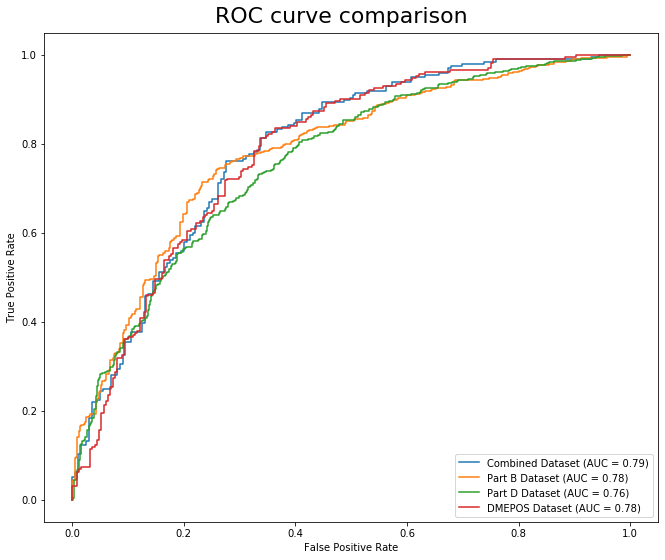

In [30]:
ROC_combined = metrics.plot_roc_curve(grid_tree_logreg_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(grid_tree_logreg_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(grid_tree_logreg_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)
ROC_dmepos = metrics.plot_roc_curve(grid_tree_logreg_dmepos, X_test_dmepos, y_test_dmepos, name="DMEPOS Dataset", ax = ROC_combined.ax_)
ROC_dmepos.figure_.suptitle("ROC curve comparison", y=.92, size=22);
ROC_combined.figure_.set_size_inches(11,9)
print("We can see from the ROC curves below that the Combined dataset performs the best.")
plt.savefig('logreg_ROC.png')

### Logistic Regression Feature Importances

Lets explore what the Logistic Regression model thought were the most valuable attributes for detecting fraud. We will focus on the Combined Dataset, because it attained the highest AUC.

In [19]:
log_perm = PermutationImportance(grid_tree_logreg_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Logistic Regression Feature Importances:')
eli5.show_weights(log_perm, feature_names=combined_feature_names)

Logistic Regression Feature Importances:


Weight,Feature
0.0671 ± 0.0151,nppes_provider_gender_M
0.0615 ± 0.0128,total_claim_count_max
0.0437 ± 0.0100,total_30_day_fill_count_std
0.0416 ± 0.0104,bene_unique_cnt_mean
0.0176 ± 0.0074,NUMBER_OF_SUPPLIERS_std
0.0141 ± 0.0121,bene_day_srvc_cnt_mean
0.0128 ± 0.0092,NUMBER_OF_SUPPLIER_CLAIMS_std
0.0101 ± 0.0036,provider_type_Pulmonary Disease
0.0088 ± 0.0044,provider_type_Podiatry
0.0073 ± 0.0071,total_30_day_fill_count_mean


# Random Forest

In [20]:
rf_b = RandomForestClassifier(n_jobs=-1)
rf_d = RandomForestClassifier(n_jobs=-1)
rf_dmepos = RandomForestClassifier(n_jobs=-1)
rf_combined = RandomForestClassifier(n_jobs=-1)

In [21]:
param_grid_rf = {  
    'n_estimators': list(range(1,2000)),
    'criterion': ['gini','entropy'],
    'max_depth': list(range(1,50)),
    'min_samples_leaf': list(range(1,50,1)),
}

In [22]:
tree_rf_b = RandomizedSearchCV(rf_b, 
                                  param_grid_rf, 
                                  cv=5,
                                  verbose=1,
                                  scoring='f1')

tree_rf_d = RandomizedSearchCV(rf_d, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

tree_rf_dmepos = RandomizedSearchCV(rf_dmepos, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

tree_rf_combined = RandomizedSearchCV(rf_combined, 
                                  param_grid_rf, 
                                  cv=5,
                                  n_jobs=-1,
                                  scoring='f1')

In [23]:
tree_rf_b.fit(X_train_b, y_train_b)
tree_rf_d.fit(X_train_d, y_train_d)
tree_rf_dmepos.fit(X_train_dmepos, y_train_dmepos)
tree_rf_combined.fit(X_train_combined, y_train_combined)

Fitting 5 folds for each of 10 candidates, totalling 50 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
[Parallel(n_jobs=1)]: Done  50 out of  50 | elapsed:  2.6min finished


RandomizedSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1), n_jobs=-1,
                   param_distributions={'criterion': ['gini', 'entropy'],
                                        'max_depth': [1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                      10, 11, 12, 13, 14, 15,
                                                      16, 17, 18, 19, 20, 21,
                                                      22, 23, 24, 25, 26, 27,
                                                      28, 29, 30, ...],
                                        'min_samples_leaf': [1, 2, 3, 4, 5, 6,
                                                             7, 8, 9, 10, 11,
                                                             12, 13, 14, 15, 16,
                                                             17, 18, 19, 20, 21,
                                                             22, 23, 24, 25, 26,
                                                          

Shown below are the confusion matrixes for each dataset. As we can see, the combined dataset has the best performance, correctly classifying 67% of the data.


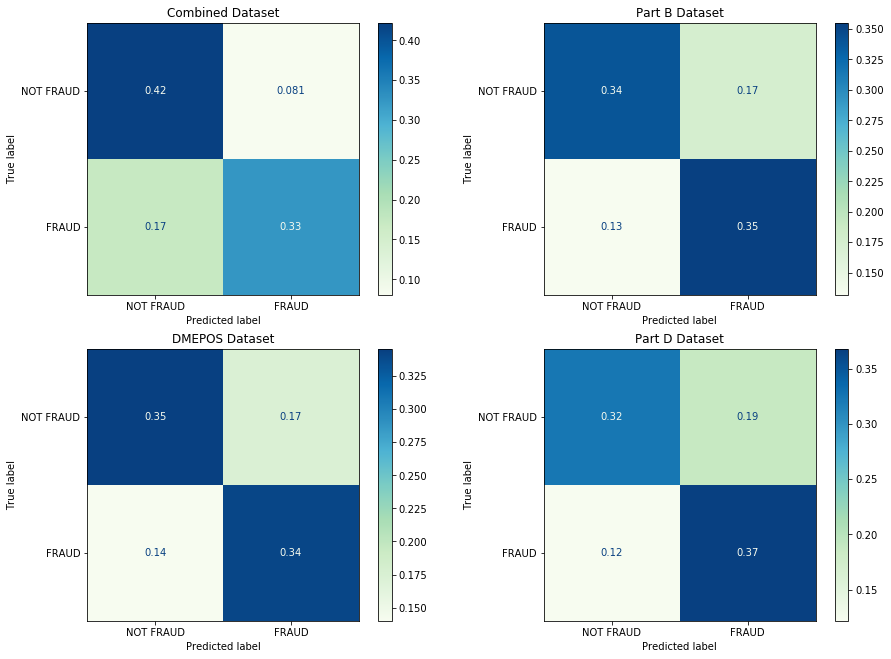

In [33]:
fig, ax = plt.subplots(2,2)
fig.set_size_inches(15, 11)


confusion_matrix_combined = metrics.plot_confusion_matrix(tree_rf_combined, X_test_combined, y_test_combined, cmap= "GnBu", ax = ax[0,0], normalize='all')
ax[0,0].set_title('Combined Dataset')
ax[0,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,0].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_partb = metrics.plot_confusion_matrix(tree_rf_b, X_test_b, y_test_b, cmap= "GnBu", ax = ax[0,1], normalize='all')
ax[0,1].set_title('Part B Dataset')
ax[0,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[0,1].set_yticklabels(['NOT FRAUD','FRAUD'])


confusion_matrix_partd = metrics.plot_confusion_matrix(tree_rf_d, X_test_d, y_test_d, cmap= "GnBu", ax = ax[1,1], normalize='all')
ax[1,1].set_title('Part D Dataset')
ax[1,1].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,1].set_yticklabels(['NOT FRAUD','FRAUD'])

confusion_matrix_dmepos = metrics.plot_confusion_matrix(tree_rf_dmepos, X_test_dmepos, y_test_dmepos, cmap= "GnBu", ax = ax[1,0], normalize='all')
ax[1,0].set_title('DMEPOS Dataset')
ax[1,0].set_xticklabels(['NOT FRAUD','FRAUD'])
ax[1,0].set_yticklabels(['NOT FRAUD','FRAUD']);

print('Shown below are the confusion matrixes for each dataset. As we can see, the combined dataset has the best performance, correctly classifying 67% of the data.')
fig.savefig('forest_confusion.png')

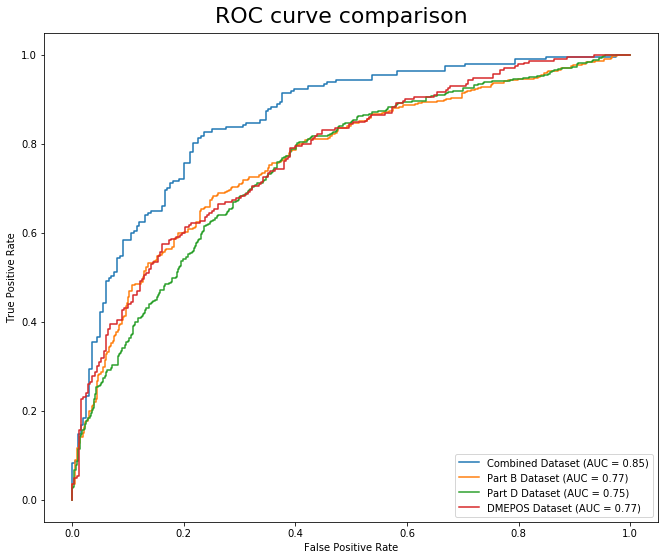

In [25]:
ROC_combined = metrics.plot_roc_curve(tree_rf_combined, X_test_combined, y_test_combined, name='Combined Dataset')
ROC_partb = metrics.plot_roc_curve(tree_rf_b, X_test_b, y_test_b, name='Part B Dataset', ax=ROC_combined.ax_)
ROC_partd = metrics.plot_roc_curve(tree_rf_d, X_test_d, y_test_d, name="Part D Dataset", ax = ROC_combined.ax_)
ROC_dmepos = metrics.plot_roc_curve(tree_rf_dmepos, X_test_dmepos, y_test_dmepos, name="DMEPOS Dataset", ax = ROC_combined.ax_)
ROC_dmepos.figure_.suptitle("ROC curve comparison", y=.92, size=22);
ROC_combined.figure_.set_size_inches(11,9)

In [26]:
tree_perm = PermutationImportance(tree_rf_combined, random_state=1).fit(X_train_combined, y_train_combined)

print('Random Forest Feature Importances:')
eli5.show_weights(tree_perm, feature_names=combined_feature_names)

Random Forest Feature Importances:


Weight,Feature
0.0257 ± 0.0076,nppes_provider_gender_M
0.0135 ± 0.0019,bene_unique_cnt_std
0.0093 ± 0.0022,line_srvc_cnt_std
0.0087 ± 0.0020,line_srvc_cnt_mean
0.0083 ± 0.0026,total_30_day_fill_count_median
0.0080 ± 0.0023,bene_unique_cnt_mean
0.0070 ± 0.0036,bene_unique_cnt_max
0.0066 ± 0.0043,total_30_day_fill_count_mean
0.0063 ± 0.0019,bene_day_srvc_cnt_std
0.0059 ± 0.0036,total_day_supply_mean
